# **Traffic Prediction**
Traffic congestion is a rising global concern that negatively impacts countries globally. The widespread consequences include time loss, freight delays, exacerbated environmental impacts, increased fuel consumption, and a diminished quality of life. (INRIX, 2025) Accurate traffic prediction not only improves network capacity utilization but also helps alleviate congestion by empowering traffic management centers (TMCs) and road operators to control traffic more effectively. (Shaygan, Meese, Li, Zhao, & Nejad, 2022) 
<br>
<br>
Due to asynchronous collection and data sparsity at various junctions, this report focuses on Junction 1. It offers the complete time series data for accurate projections.

**Note**: The dataset does not specify a country name. Consequently, holiday effects were modeled under the assumption that the data is from the United States, which may affect the accuracy of the results.

## **Which exogenous variables affect traffic jam?** <br>
1. **Holiday** <br>
In the United States, many people prefers automobile travel over air transport during the holiday season. (FOX40 News, 2025)
2. **Season** <br>
A study by Dr. Jean Andrey and Daniel Unrau found that traffic collisions increase by around 50 percent during snow and rain. From rainy or foggy weather, to the extreme snowstorm that stops drivers in their tracks. (GEOTAB, 2024)
3. **Weekday or Weekend** <br>
Weekend travel behavior is expected to be substantially different from the weekday travel behavior for difference in several spatial and temporal constraints. (Agarwal, 2004)


## **Import Library**

In [95]:
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

## **Import Dataset**

In [2]:
data = pd.read_csv('traffic.csv')
traffic = pd.DataFrame(data)
traffic.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [4]:
traffic.shape

(48120, 4)

In [3]:
# filter junction 1
# drop ID and Junction
df = traffic[traffic['Junction'] == 1]
df = df.drop(columns= ['ID', 'Junction'])
df

,DateTime,Vehicles
0,2015-11-01 00:00:00,15
1,2015-11-01 01:00:00,13
2,2015-11-01 02:00:00,10
3,2015-11-01 03:00:00,7
4,2015-11-01 04:00:00,9
...,...,...
14587,2017-06-30 19:00:00,105
14588,2017-06-30 20:00:00,96
14589,2017-06-30 21:00:00,90
14590,2017-06-30 22:00:00,84


In [6]:
# no missing values
missing_values = df.isna().sum()
print("Total missing values per column:")
print(missing_values)

Total missing values per column:
DateTime    0
Vehicles    0
dtype: int64


In [7]:
# no duplicated rows
duplicates = df.duplicated().sum()
print("Total duplicated rows:", duplicates)

Total duplicated rows: 0


## **Data Pre-processing**

In [4]:
# set DateTime as an index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df.sort_index()

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
...,...
2017-06-30 19:00:00,105
2017-06-30 20:00:00,96
2017-06-30 21:00:00,90


is_weekend

In [5]:
# dayofweek starts from Monday as 0 to Sunday as 6
# 1 is weekend
# 0 is weekday
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

is_holiday

In [6]:
holiday = holidays.US(years=[2015, 2016, 2017])
df['is_holiday'] = df.index.normalize().isin(holiday).astype(int)

season

In [7]:
def month_to_season(month):
    if month in [12, 1 , 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

df['season'] = df.index.month.map(month_to_season)
# convert into dummy variables
# avoid multicolliearity
season_dummies = pd.get_dummies(df['season'], prefix = 'season', drop_first= True, dtype=int) # autumn is a reference level
df.drop(columns = 'season', inplace = True)
df_dummies = pd.concat([df, season_dummies], axis = 1)
df_dummies

,Vehicles,is_weekend,is_holiday,season_spring,season_summer,season_winter
DateTime,,,,,,
2015-11-01 00:00:00,15,1,0,0,0,0
2015-11-01 01:00:00,13,1,0,0,0,0
2015-11-01 02:00:00,10,1,0,0,0,0
2015-11-01 03:00:00,7,1,0,0,0,0
2015-11-01 04:00:00,9,1,0,0,0,0
...,...,...,...,...,...,...
2017-06-30 19:00:00,105,0,0,0,1,0
2017-06-30 20:00:00,96,0,0,0,1,0
2017-06-30 21:00:00,90,0,0,0,1,0


Now, the dataframe is ready for splitting

## **Exploratory Data Analysis**

In [12]:
# temporary dataframe for EDA
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_of_week
df['month'] = df.index.month
df['year'] = df.index.year
df['season'] = df.index.month.map(month_to_season)
df['is_holiday'] = df.index.normalize().isin(holiday).astype(int)
df

,Vehicles,is_weekend,is_holiday,hour,day_of_week,month,year,season
DateTime,,,,,,,,
2015-11-01 00:00:00,15,1,0,0,6,11,2015,autumn
2015-11-01 01:00:00,13,1,0,1,6,11,2015,autumn
2015-11-01 02:00:00,10,1,0,2,6,11,2015,autumn
2015-11-01 03:00:00,7,1,0,3,6,11,2015,autumn
2015-11-01 04:00:00,9,1,0,4,6,11,2015,autumn
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,105,0,0,19,4,6,2017,summer
2017-06-30 20:00:00,96,0,0,20,4,6,2017,summer
2017-06-30 21:00:00,90,0,0,21,4,6,2017,summer


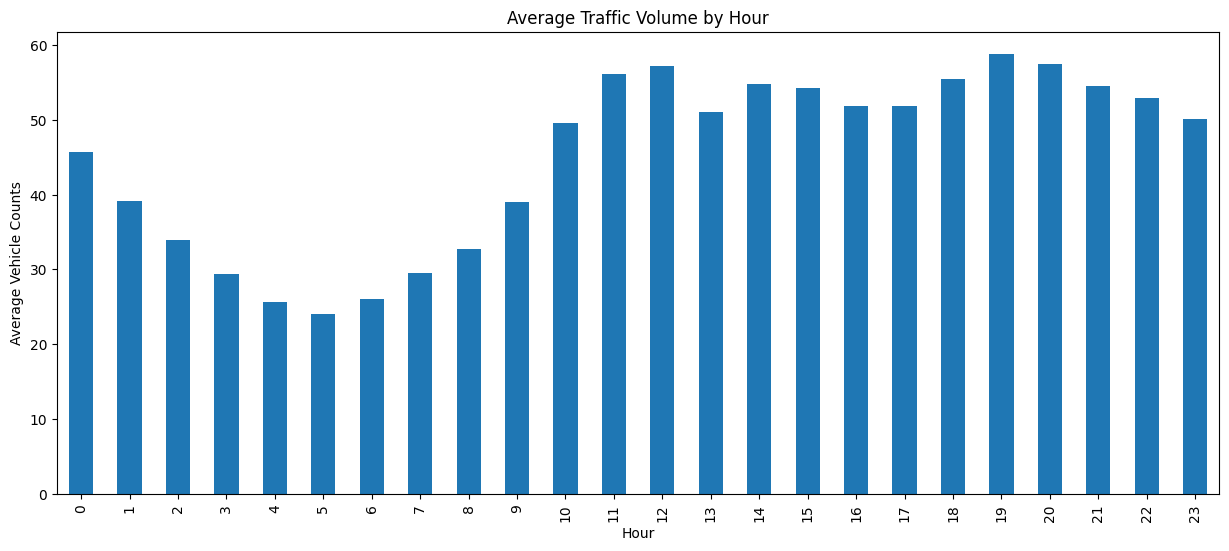

In [13]:
plt.figure(figsize=(15, 6))
df.groupby('hour')['Vehicles'].mean().plot(kind= 'bar')
plt.title('Average Traffic Volume by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Vehicle Counts')
plt.show()

Average traffic volume reaches the peaks at noon and 7 p.m.

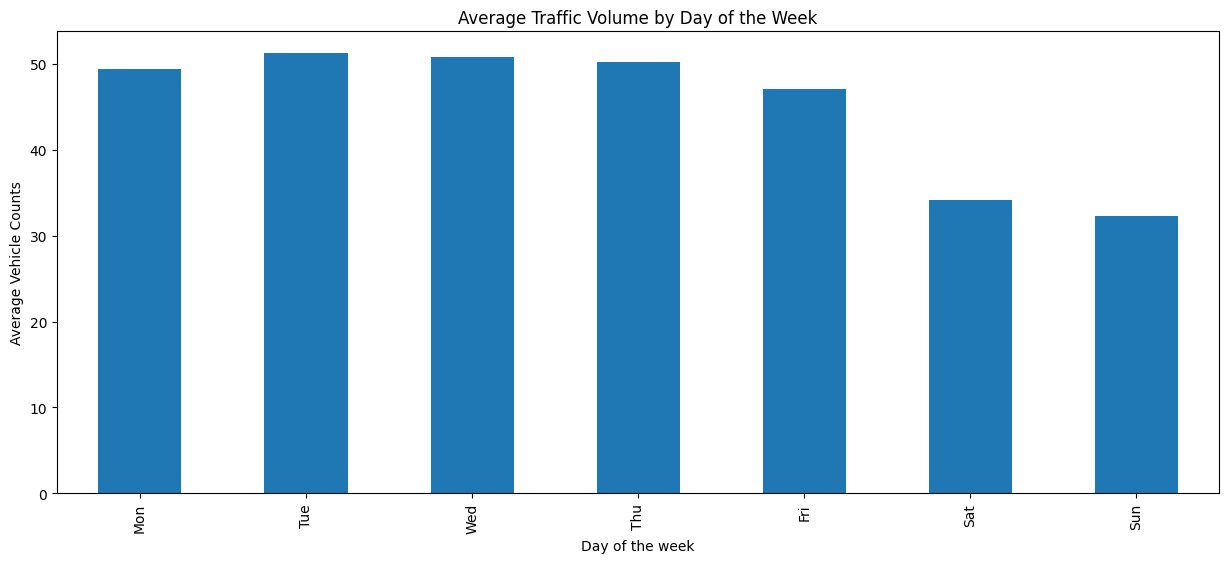

In [14]:
plt.figure(figsize=(15, 6))
df.groupby('day_of_week')['Vehicles'].mean().plot(kind= 'bar')
plt.title('Average Traffic Volume by Day of the Week')
plt.xlabel('Day of the week')
plt.xticks(ticks = np.arange(7), labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Average Vehicle Counts')
plt.show()

The average traffic volume on weekdays is statistically higher compared to weekends.

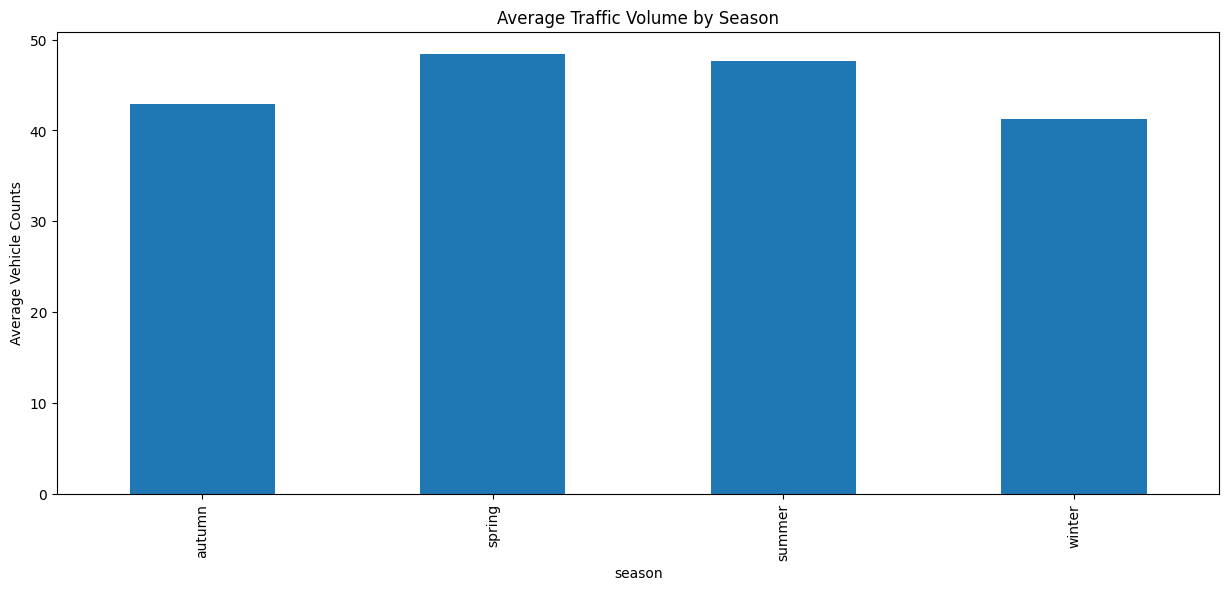

In [15]:
plt.figure(figsize=(15, 6))
df.groupby('season')['Vehicles'].mean().plot(kind = 'bar')
plt.title('Average Traffic Volume by Season')
plt.xlabel('season')
plt.ylabel('Average Vehicle Counts')
plt.show()

On average, traffic volume is highest in spring, followed by summer, autumn, and winter.

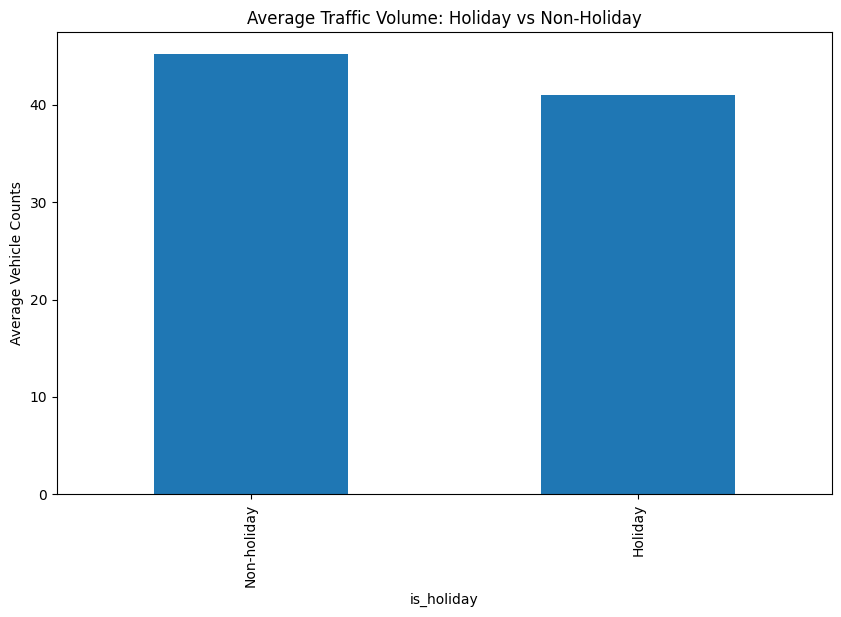

In [16]:
plt.figure(figsize=(10, 6))
df.groupby('is_holiday')['Vehicles'].mean().plot(kind='bar')
plt.title('Average Traffic Volume: Holiday vs Non-Holiday')
plt.xlabel('is_holiday')
plt.xticks(ticks = [0, 1], labels= ['Non-holiday', 'Holiday'])
plt.ylabel('Average Vehicle Counts')
plt.show()


Non-holiday periods exhibit a higher average traffic volume compared to holidays.

STL decomposition (additive model)

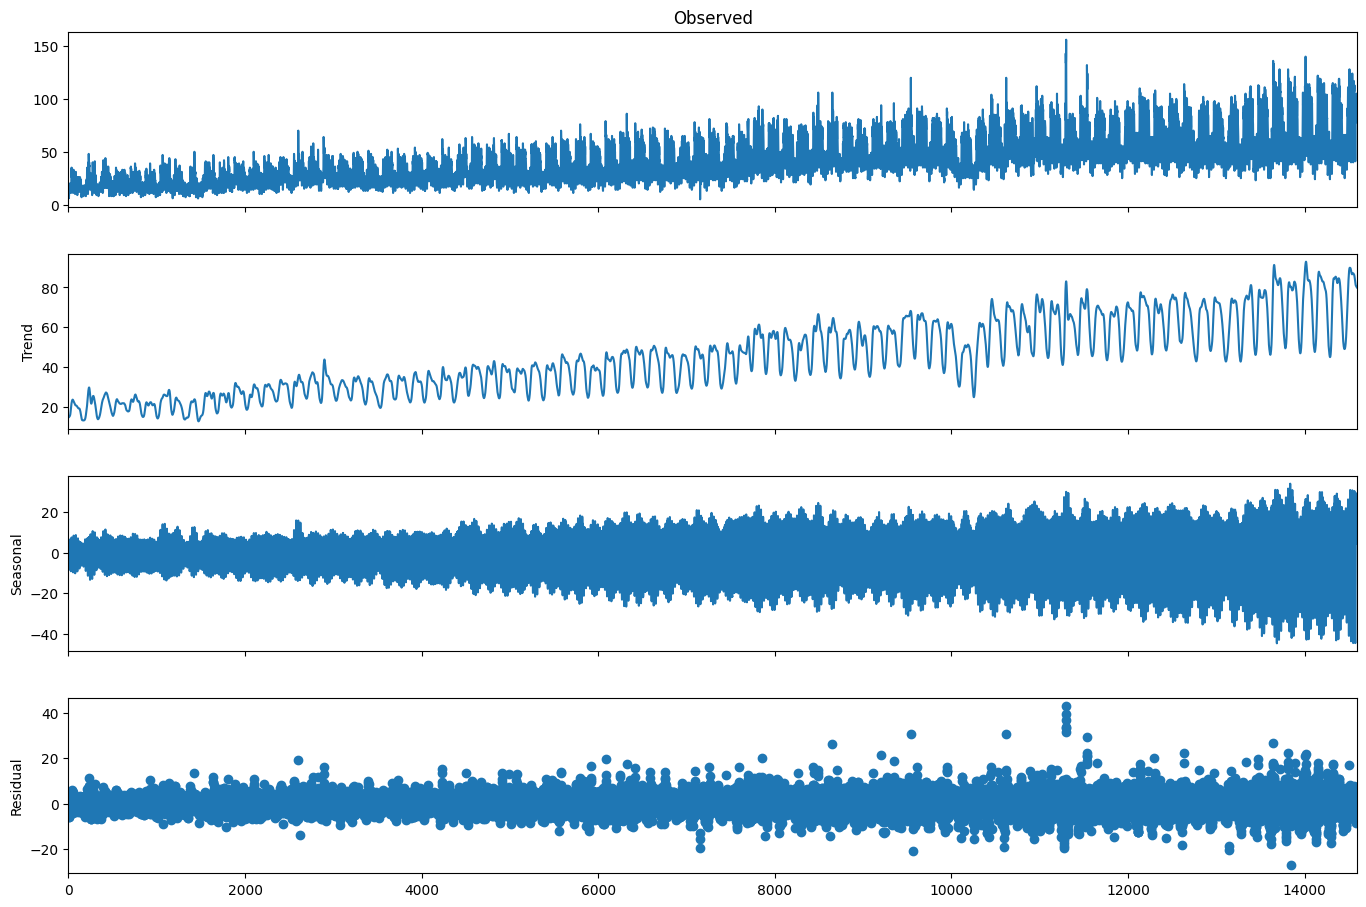

In [17]:
# hourly traffic with daily seasonality
vehicles_array = np.array(df['Vehicles'])
add = STL(vehicles_array, period=24)
res = add.fit()
fig = res.plot()
fig.set_size_inches(15, 10)
plt.show()

STL decomposition (multiplicative model)

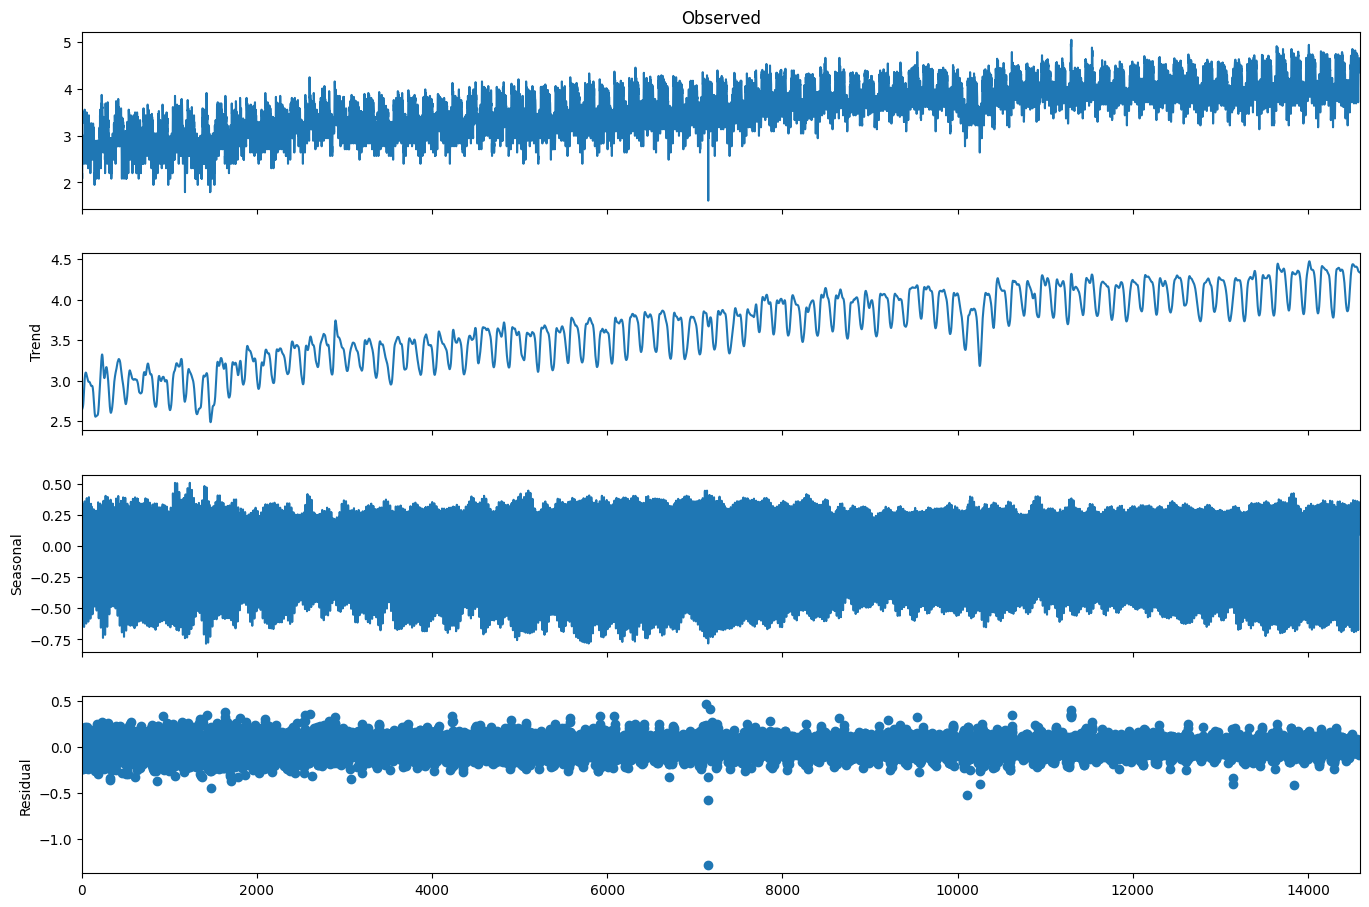

In [18]:
mult = STL(np.log(vehicles_array), period=24)
res = mult.fit()
fig = res.plot()
fig.set_size_inches(15, 10)
plt.show()

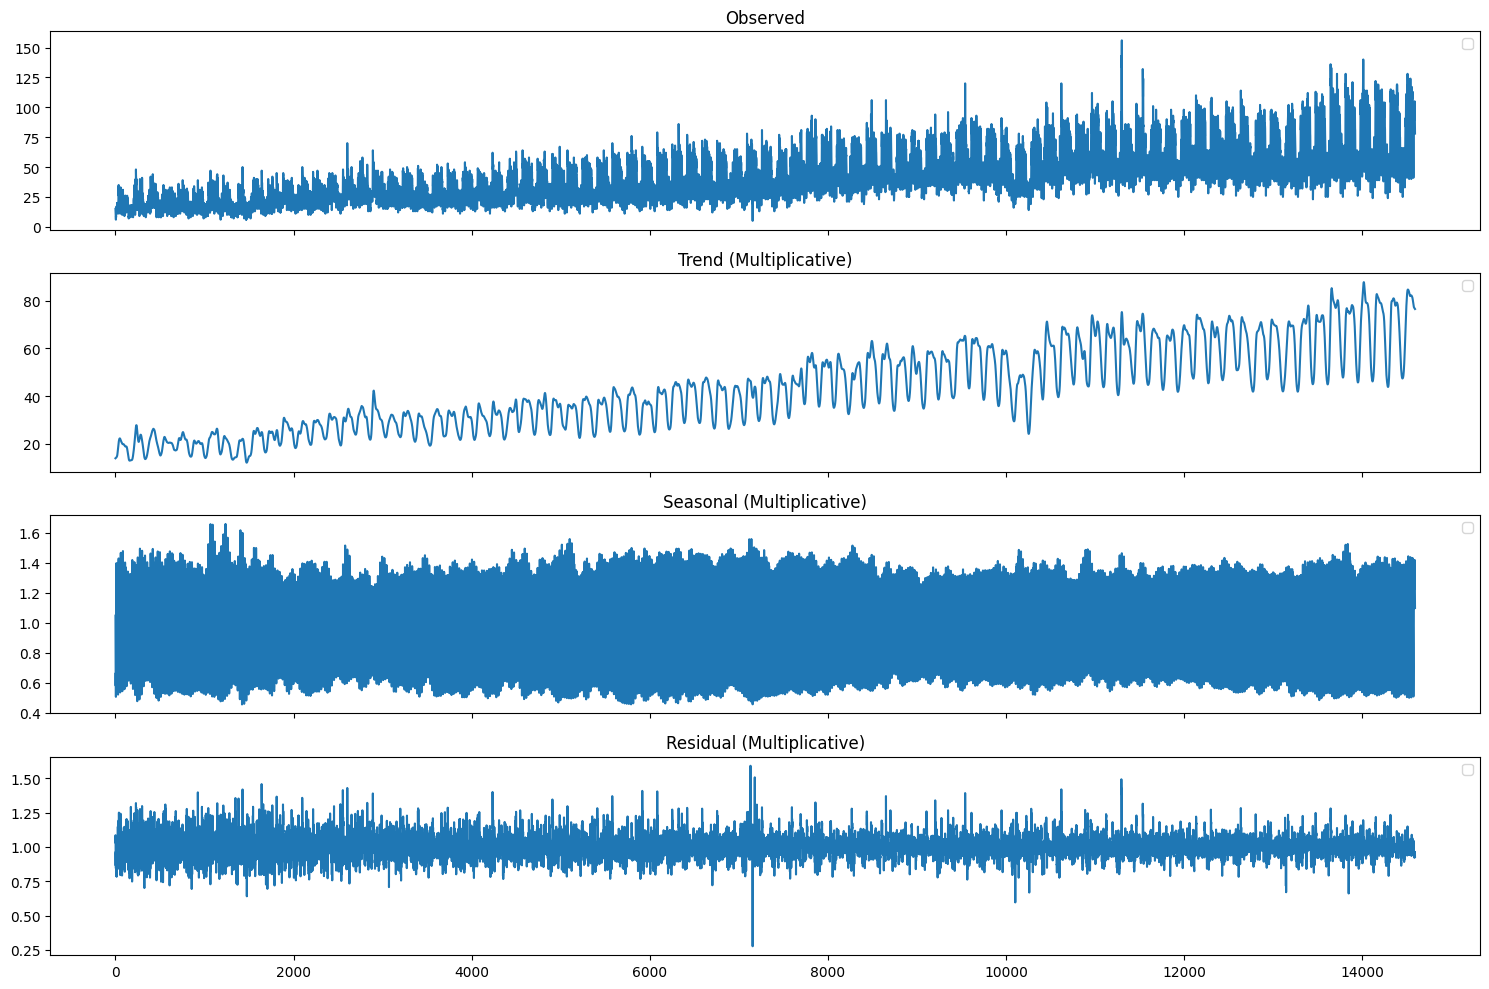

In [19]:
# take exponential to convert into original scale
trend_mult = np.exp(res.trend)
seasonal_mult = np.exp(res.seasonal)
resid_mult = np.exp(res.resid)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex = True)

axes[0].plot(vehicles_array)
axes[0].set_title('Observed')
axes[0].legend()

axes[1].plot(trend_mult)
axes[1].set_title('Trend (Multiplicative)')
axes[1].legend()

axes[2].plot(seasonal_mult)
axes[2].set_title('Seasonal (Multiplicative)')
axes[2].legend()

axes[3].plot(resid_mult)
axes[3].set_title('Residual (Multiplicative)')
axes[3].legend()

plt.tight_layout()
plt.show()

The multiplicative model is more appropriate because the magnitude of seasonal variation grows proportionally with level of time series. Moreover, this helps stabilize variance over time.

## **Splitting Data**
80% training set <br>
20% test set

In [9]:
split_idx = int(len(df_dummies) * 0.8)
# take all columns and all rows from index position 0 up to split_idx − 1
train = df_dummies.iloc[: split_idx]
test = df_dummies.iloc[split_idx :]

train

,Vehicles,is_weekend,is_holiday,season_spring,season_summer,season_winter
DateTime,,,,,,
2015-11-01 00:00:00,15,1,0,0,0,0
2015-11-01 01:00:00,13,1,0,0,0,0
2015-11-01 02:00:00,10,1,0,0,0,0
2015-11-01 03:00:00,7,1,0,0,0,0
2015-11-01 04:00:00,9,1,0,0,0,0
...,...,...,...,...,...,...
2017-03-01 04:00:00,42,0,0,1,0,0
2017-03-01 05:00:00,39,0,0,1,0,0
2017-03-01 06:00:00,43,0,0,1,0,0


In [10]:
exog_train, exog_test = train.drop(columns = 'Vehicles'), test.drop(columns = 'Vehicles')
X_train, X_test =  train[['Vehicles']], test[['Vehicles']]

print(type(X_train))
display(X_train)

print(type(exog_train))
display(exog_train)

<class 'pandas.core.frame.DataFrame'>


,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
...,...
2017-03-01 04:00:00,42
2017-03-01 05:00:00,39
2017-03-01 06:00:00,43


<class 'pandas.core.frame.DataFrame'>


,is_weekend,is_holiday,season_spring,season_summer,season_winter
DateTime,,,,,
2015-11-01 00:00:00,1,0,0,0,0
2015-11-01 01:00:00,1,0,0,0,0
2015-11-01 02:00:00,1,0,0,0,0
2015-11-01 03:00:00,1,0,0,0,0
2015-11-01 04:00:00,1,0,0,0,0
...,...,...,...,...,...
2017-03-01 04:00:00,0,0,1,0,0
2017-03-01 05:00:00,0,0,1,0,0
2017-03-01 06:00:00,0,0,1,0,0


## **SARIMA**

### <span style="color:orange"> stationary test </span><br>
ADF Test <br>
$H_0$: Time series is non stationary. <br>
$H_1$: Time series is stationary. <br>
<br>
KPSS Test<br>
$H_0$: Time series is stationary. <br>
$H_1$: Time series is non stationary. <br>

In [30]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

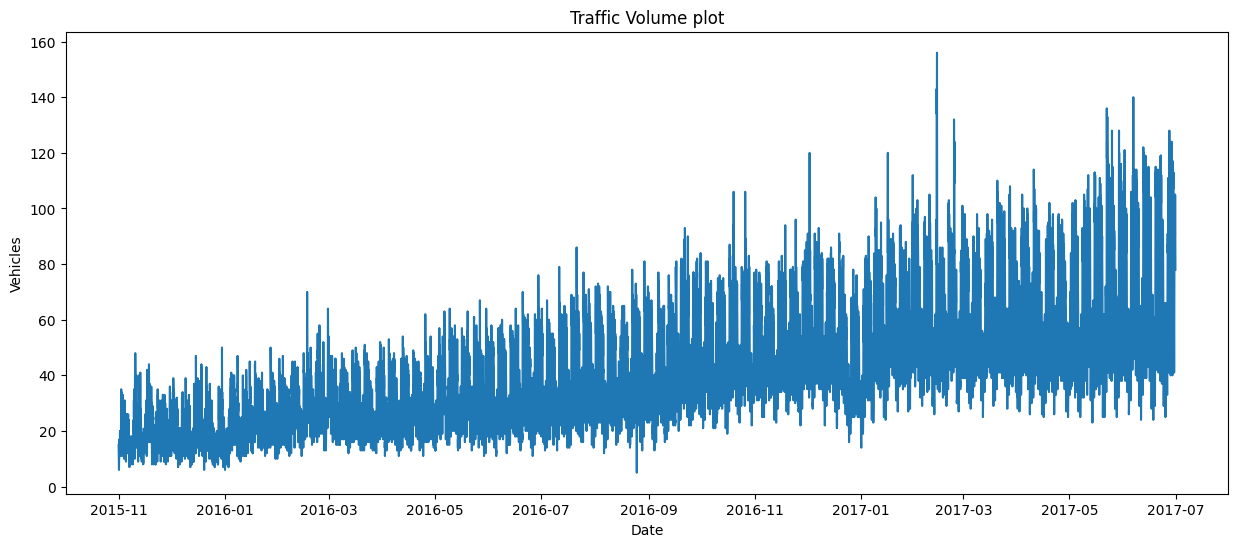

In [23]:
plt.figure(figsize=(15,6))
plt.plot(df_dummies['Vehicles'])
plt.title('Traffic Volume plot')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

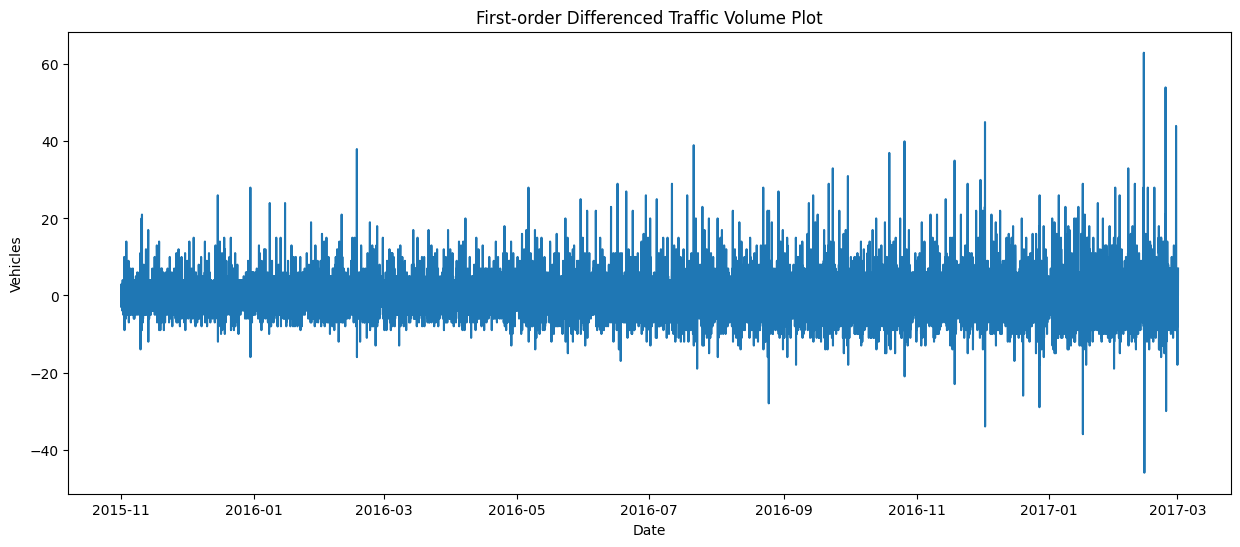

In [40]:
vehicle_diff = X_train.diff().dropna()

plt.figure(figsize=(15,6))
plt.plot(vehicle_diff)
plt.title('First-order Differenced Traffic Volume Plot')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()


In [41]:
# p-value = 0.00 < 0.05 -> reject H0 TS is stationary
adf_test(vehicle_diff)
# p-value = 0.10 > 0.05 -> fail to reject H0 TS is stationary
kpss_test(vehicle_diff)

Results of Dickey-Fuller Test:
Test Statistic                   -20.075875
p-value                            0.000000
#Lags Used                        37.000000
Number of Observations Used    11634.000000
Critical Value (1%)               -3.430912
Critical Value (5%)               -2.861788
Critical Value (10%)              -2.566902
dtype: float64
Results of KPSS Test:
Test Statistic            0.003394
p-value                   0.100000
Lags Used                78.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


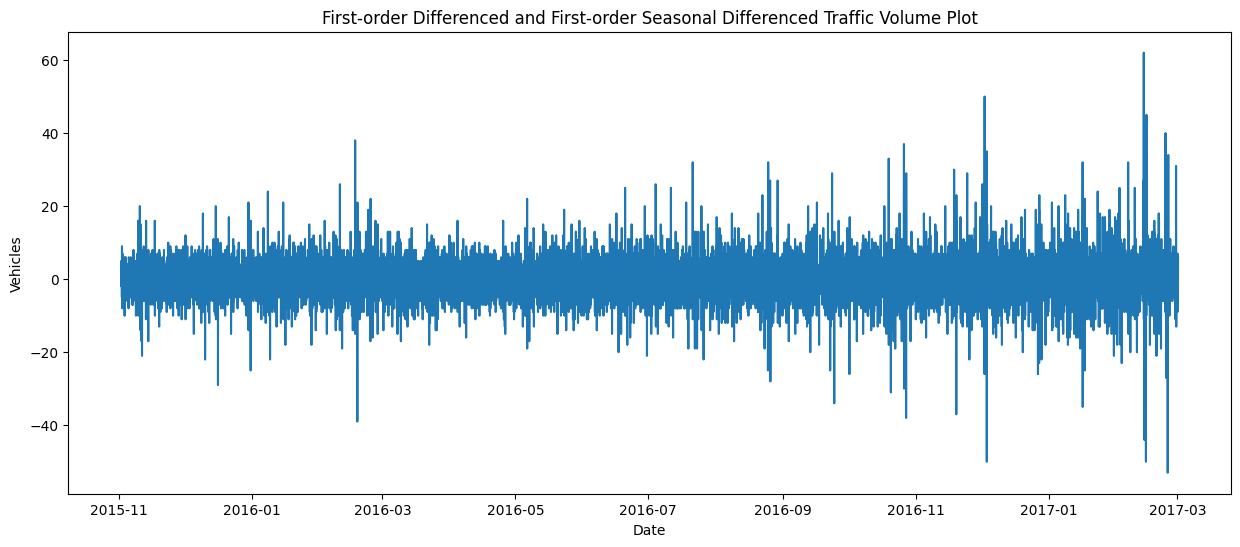

In [42]:
# daily seasonality 
vehicle_seasonal_diff = vehicle_diff.diff(periods= 24).dropna()

plt.figure(figsize=(15,6))
plt.plot(vehicle_seasonal_diff)
plt.title('First-order Differenced and First-order Seasonal Differenced Traffic Volume Plot')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.show()

In [43]:
# p-value = 0.00 < 0.05 -> reject H0 TS is stationary
adf_test(vehicle_seasonal_diff)
# p-value = 0.10 > 0.05 -> fail to reject H0 TS is stationary
kpss_test(vehicle_seasonal_diff)

Results of Dickey-Fuller Test:
Test Statistic                   -27.650544
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    11619.000000
Critical Value (1%)               -3.430913
Critical Value (5%)               -2.861789
Critical Value (10%)              -2.566902
dtype: float64
Results of KPSS Test:
Test Statistic            0.001509
p-value                   0.100000
Lags Used                43.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


d = 1 <br>
D = 1 <br>
s = 24 <br>
After differencing, Time series becomes stationary. <br>

### <span style="color:orange"> PACF and ACF plot </span><br>

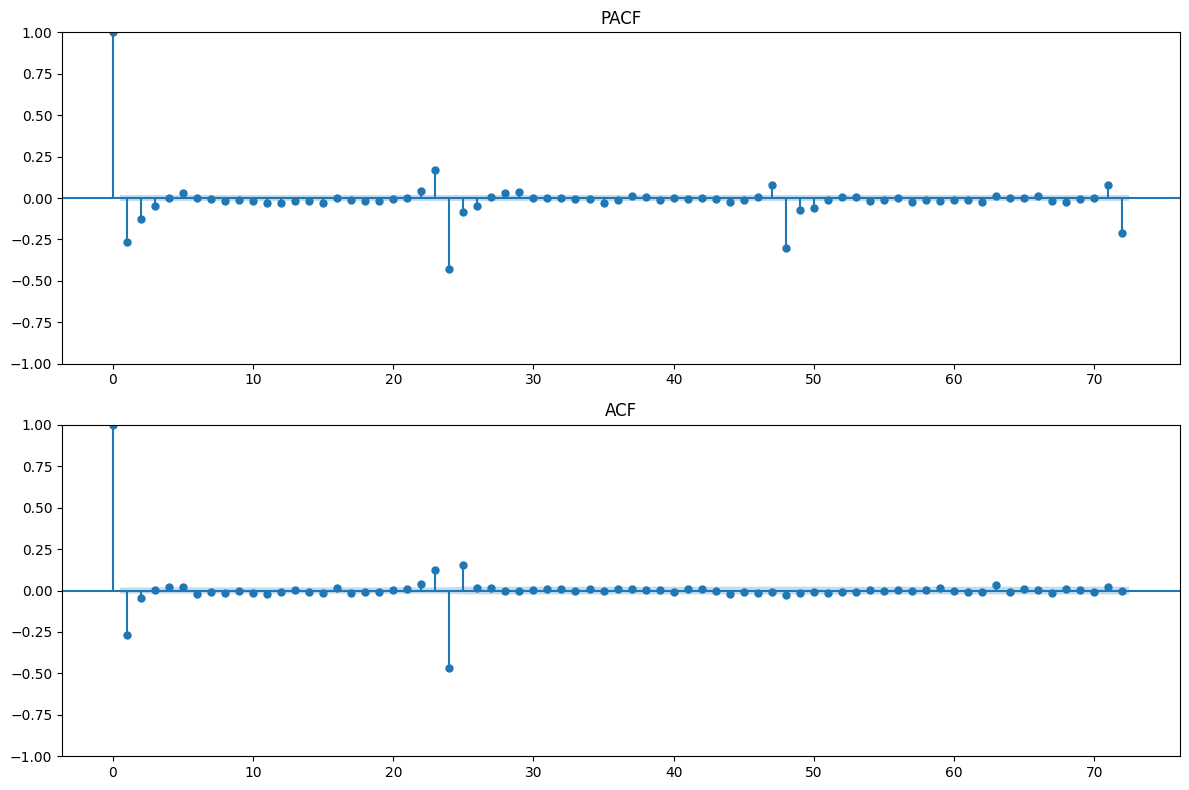

In [44]:
fig, axes = plt.subplots(2,1, figsize = (12,8))

plot_pacf(vehicle_seasonal_diff, lags=72, ax = axes[0])
axes[0].set_title('PACF')

plot_acf(vehicle_seasonal_diff, lags=72, ax = axes[1])
axes[1].set_title('ACF')

plt.tight_layout()
plt.show()

suggested order is no more than <br>
p = 3 <br>
P = 3 <br>
q = 2 <br>
Q = 2 <br>
Given the model's complexity and the computational cost of an exhaustive grid search, the possible combinations are limited.

In [29]:
p_vals = range(3)
P_vals = range(3)
q_vals = range(3)
Q_vals = range(3)
d = 1
D = 1 
seasonal_period = 24

parameters = product(p_vals, q_vals, P_vals, Q_vals)
parameters_list = list(parameters)
len(parameters_list)
# search the best model through 81 fits 

81

In [54]:
def GridSearch_SARIMA(df, parameters_list, d, D, seasonal_period):
    results = []
    
    for p, q, P, Q in tqdm(parameters_list):
         # Skip trivial model
        if p == 0 and q == 0 and P == 0 and Q == 0:
            continue

        # Prevent complex model
        if p + q + P + Q > 4:
            continue

        try:
            model = SARIMAX(
                df,
                order=(p, d, q),
                seasonal_order=(P, D, Q, seasonal_period),
                enforce_invertibility= False,
                enforce_stationarity= False
            )

            res = model.fit(
                maxiter=50,
                disp=False
            )

            results.append({
                'p': p,
                'q': q,
                'P': P,
                'Q': Q,
                'AIC': res.aic
            })

        except:
            continue

    return pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)

In [31]:
result = GridSearch_SARIMA(X_train, parameters_list, d, D, seasonal_period)
result.head(10)

100%|██████████| 81/81 [56:15<00:00, 41.67s/it]   


,p,q,P,Q,AIC
0,0,2,0,2,64774.687953
1,0,1,1,2,64776.990583
2,1,1,0,2,64781.870156
3,2,0,0,2,64783.311379
4,0,1,2,1,64787.635990
5,0,1,0,2,64787.876740
6,1,2,0,1,64902.203083
7,2,1,0,1,64903.322231
8,0,2,0,1,64905.334300
9,2,0,1,1,64908.637830


In [64]:
best_sarima = SARIMAX(X_train, 
                      order=(0,1,2),
                      seasonal_order=(0,1,2,24),
                      enforce_invertibility= False,
                      enforce_stationarity= False).fit()
print(best_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Vehicles   No. Observations:                11673
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 24)   Log Likelihood              -32382.344
Date:                            Thu, 18 Dec 2025   AIC                          64774.688
Time:                                    21:39:10   BIC                          64811.480
Sample:                                11-01-2015   HQIC                         64787.051
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2768      0.006    -47.596      0.000      -0.288      -0.265
ma.L2         -0.0288      0.007   

$$(1-B)(1-B^{24})X_t = (1+\theta_1B+\theta_2B^2)(1+\Theta_1B^{24}+\Theta_2B^{48})Z_t $$
$$X_t = X_{t-1} + X_{t-24} - X_{t-25} + Z_t + \theta_1 Z_{t-1} + \theta_2 Z_{t-2} + \Theta_1 Z_{t-24} + \theta_1\Theta_1 Z_{t-25} + \theta_2\Theta_1 Z_{t-26} + \Theta_2 Z_{t-48} + \theta_1\Theta_2 Z_{t-49} + \theta_2\Theta_2 Z_{t-50}$$


### <span style='color:orange'> Ljung-Box test </span></br>
$H_0$: Residual is uncorrelated. (white noise process)</br>
$H_1$: Residual exhibits autocorrelation.</br>
As p-value = 0.93 which is greater than 0.05, fail to reject the null hypothesis. There is insufficient evidence to conclude that residual exhibits autocorrelation at 5% significance level.

### <span style='color:orange'> Heteroscedasticity test </span></br>
$H_0$: no heteroscedasticity</br>
$H_1$: heteroscedasticity occurs</br>
As p-value = 0.0 which is less than 0.05, reject the null hypothesis. There is sufficient evidence to conclude that heteroscedasticity occurs at 5% significance level.

In [67]:
# prediction
pred_sarima = best_sarima.get_prediction(start=X_test.index[0], end=X_test.index[-1], dynamic = False)
point_forecast_sarima = pred_sarima.predicted_mean
point_forecast_sarima.index == X_test.index

print(point_forecast_sarima.head())

2017-03-01 09:00:00    57.638428
2017-03-01 10:00:00    72.343779
2017-03-01 11:00:00    77.927744
2017-03-01 12:00:00    78.747166
2017-03-01 13:00:00    71.475668
Freq: h, Name: predicted_mean, dtype: float64


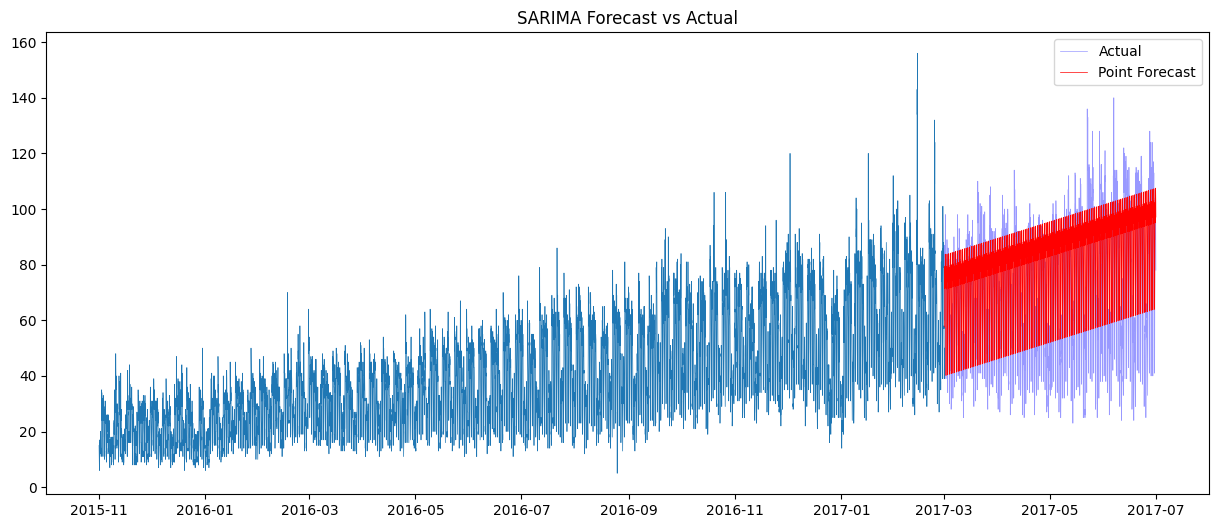

In [68]:
plt.figure(figsize=(15,6))

# Plot historical and actual data
plt.plot(X_train, linewidth = 0.5)
plt.plot(X_test, label='Actual', color='blue', alpha=0.4, linewidth = 0.5)

# Plot the Point Forecast (The Mean)
plt.plot(point_forecast_sarima, color='red', label='Point Forecast', linewidth = 0.5)

plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()

In [81]:
# error metrics
rmse_sarima = np.sqrt(mean_squared_error(X_test, point_forecast_sarima))
mae_sarima = mean_absolute_error(X_test, point_forecast_sarima)
mape_sarima = mean_absolute_percentage_error(X_test, point_forecast_sarima)

print(f'RMSE: {rmse_sarima:.2f}')
print(f'MAE: {mae_sarima:.2f}')
print(f'MAPE: {mape_sarima*100:.2f}%')

RMSE: 19.25
MAE: 14.89
MAPE: 29.09%


In [70]:
# AIC increase when using
# exog_train['is_holiday']
# exog_train[['season_summer', 'season_spring', 'season_winter']]
# and exog_train
best_sarimax = SARIMAX(X_train,
                      exog = exog_train['is_weekend'], 
                      order=(0,1,2),
                      seasonal_order=(0,1,2,24),
                      enforce_invertibility= False,
                      enforce_stationarity= False).fit()
best_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Vehicles   No. Observations:                11673
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 24)   Log Likelihood              -32380.807
Date:                            Thu, 18 Dec 2025   AIC                          64773.614
Time:                                    21:47:43   BIC                          64817.765
Sample:                                11-01-2015   HQIC                         64788.449
                                     - 03-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_weekend    -0.5590      0.378     -1.478      0.139      -1.300       0.182
ma.L1         -0.2778      0.006    -47.768      0.000      -0.289      -0.266
ma.L2         -0.0305      0.007     -4.284      0.000      -0.044      -0.017
ma.S.L24      -0.9247      0.008   -118.261      0.000      -0.940      -0.909
ma.S.L48      -0.0379      0.008     -4.931      0.000      -0.053      -0.023
sigma2        15.5248      0.075    208.128      0.000      15.379      15.671
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             92550.65
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                             1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It is not worth including exogenous variables, as the AIC does not decrease much.

To conclude, the $SARIMA(0,1,2)\times(0,1,2)_{12}$ model can capture the traffic data well. However, the residual variance is non-constant.

## **Exponential Smoothing**
The traffic data contains both trend and seasonality. Multiplicative Holt-winter's exponential smoothing will be deployed. 

In [91]:
hw_model = ExponentialSmoothing(X_train, trend='add',
                                seasonal='mul', seasonal_periods=24).fit()
forecast_hw = hw_model.forecast(steps= len(X_test))

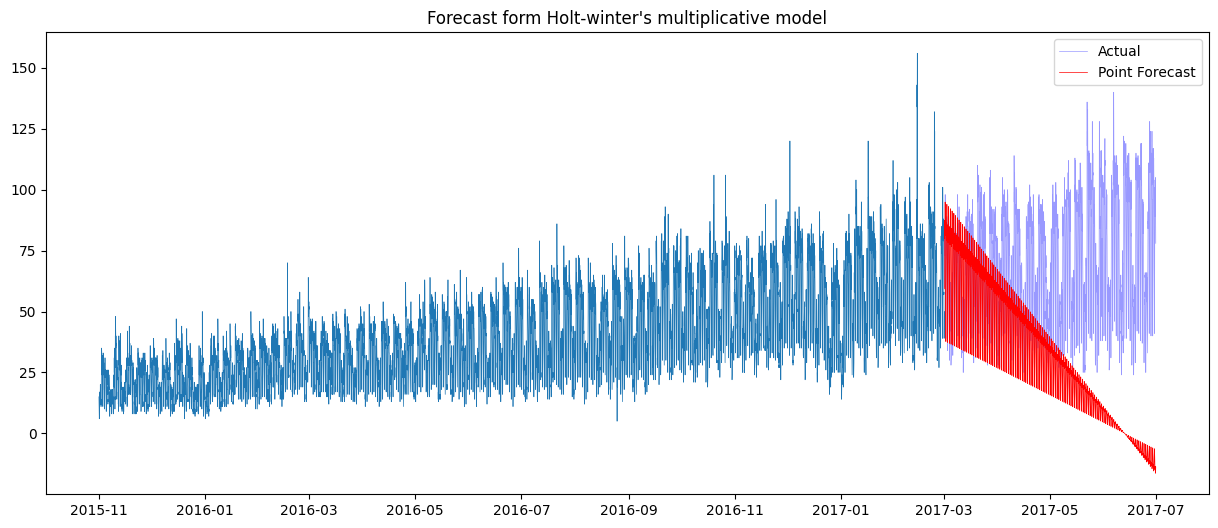

In [92]:
plt.figure(figsize=(15,6))

# Plot historical and actual data
plt.plot(X_train, linewidth = 0.5)
plt.plot(X_test, label='Actual', color='blue', alpha=0.4, linewidth = 0.5)

# Plot the Point Forecast
plt.plot(forecast_hw, color='red', label='Point Forecast', linewidth = 0.5)

plt.legend()
plt.title("Forecast form Holt-winter's multiplicative model")
plt.show()

In [93]:
# error metrics
rmse_hw = np.sqrt(mean_squared_error(X_test, forecast_hw))
mae_hw = mean_absolute_error(X_test, forecast_hw)
mape_hw = mean_absolute_percentage_error(X_test, forecast_hw)

print(f'RMSE: {rmse_hw:.2f}')
print(f'MAE: {mae_hw:.2f}')
print(f'MAPE: {mape_hw*100:.2f}%')

RMSE: 51.33
MAE: 40.17
MAPE: 56.92%


The Holt-Winters multiplicative model does not fit the traffic dataset well.

## **Prophet**

In [108]:
# initialize prophet dataseet
df_prophet = pd.DataFrame(
    {'ds': X_train.index,
     'y': X_train['Vehicles']})

In [ ]:
# define prohet model
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(df_prophet)

02:26:30 - cmdstanpy - INFO - Chain [1] start processing
02:26:33 - cmdstanpy - INFO - Chain [1] done processing


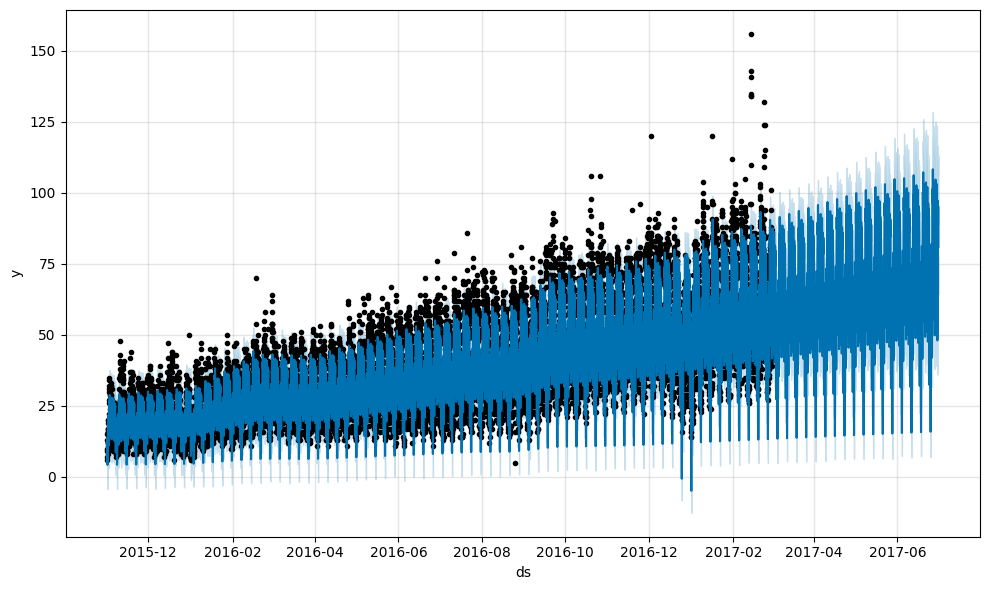

In [120]:
# forecasting
future = prophet_model.make_future_dataframe(periods= len(X_test), freq='H')
fcst = prophet_model.predict(future)
fig = prophet_model.plot(fcst)

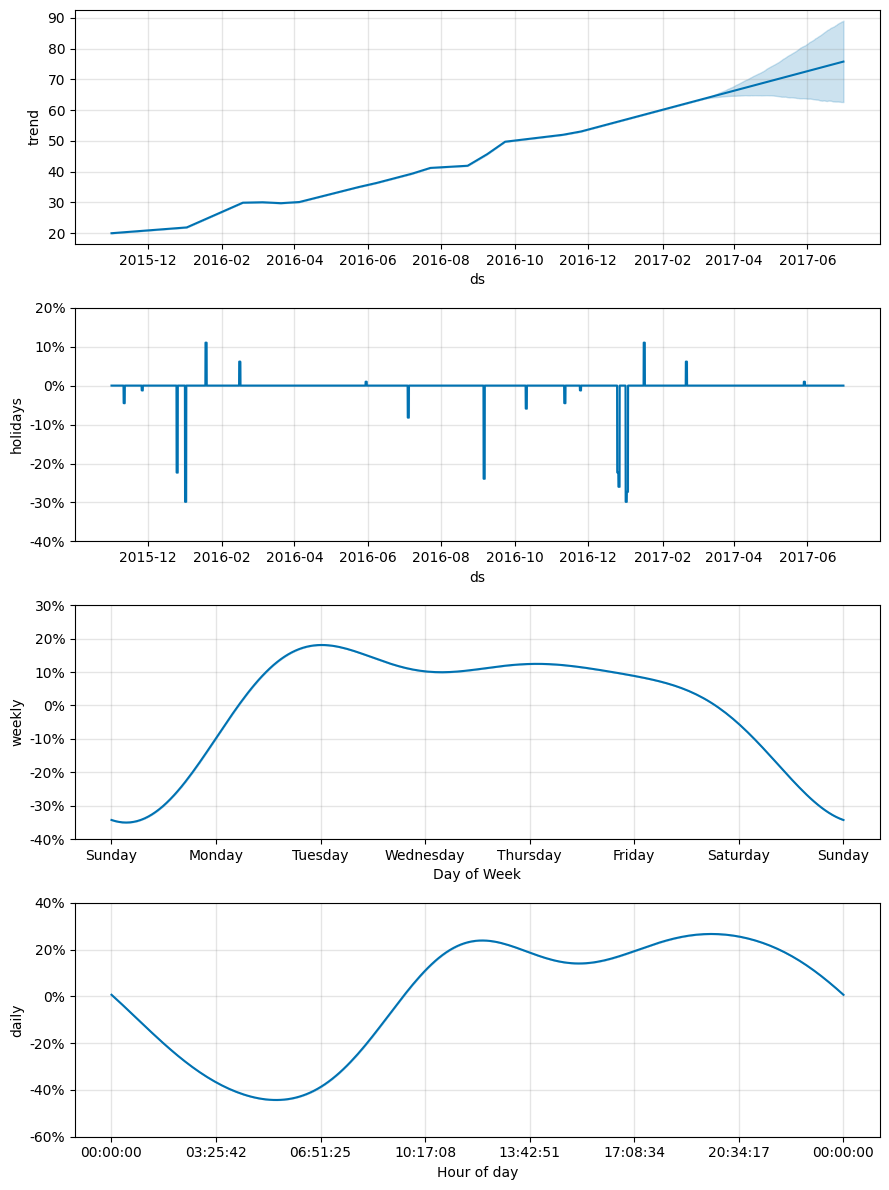

In [121]:
fig = prophet_model.plot_components(fcst)

In [122]:
fcst['yhat']

0        13.281860
1        10.760243
2         8.328442
3         6.324231
4         4.931061
           ...    
14587    95.246828
14588    94.886878
14589    92.459080
14590    87.898599
14591    81.051508
Name: yhat, Length: 14592, dtype: float64

In [123]:
# error metrics
# get only the forecasted part to match test set
test_forecast = fcst[-len(X_test):]['yhat']

rmse_prophet = np.sqrt(mean_squared_error(X_test, test_forecast))
mae_prophet = mean_absolute_error(X_test, test_forecast)
mape_prophet = mean_absolute_percentage_error(X_test, test_forecast)

print(f'RMSE: {rmse_prophet:.2f}')
print(f'MAE: {mae_prophet:.2f}')
print(f'MAPE: {mape_prophet*100:.2f}%')

RMSE: 9.47
MAE: 7.50
MAPE: 13.00%


In [126]:
metrics_df = pd.DataFrame({
    'Metrics':['RMSE', 'MAE', 'MAPE'],
    'SARIMA': [rmse_sarima, mae_sarima, mape_sarima],
    "Holt-Winter's": [rmse_hw, mae_hw, mape_hw],
    'Prophet': [rmse_prophet, mae_prophet, mape_prophet]})
metrics_df.round(4)

,Metrics,SARIMA,Holt-Winter's,Prophet
0,RMSE,19.2464,51.3292,9.4667
1,MAE,14.8871,40.1727,7.4987
2,MAPE,0.2909,0.5692,0.1300


## **Conclusion**
The Prophet model is the most suitable for this dataset. It captures detailed seasonal patterns and holiday effects, facilitating a deeper understanding of the traffic volume over time. Furthermore, it outperforms both SARIMA and the multiplicative Holt-Winters model while requiring significantly less computational time and data preprocessing.